In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
print(chars, '\n')
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
print(stoi , '\n')
itos = {i:s for s,i in stoi.items()}
print(itos , '\n')
vocab_size = len(itos)
print(vocab_size)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0} 

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} 

27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])                               #80%
Xdev, Ydev = build_dataset(words[n1:n2])                           #10%
Xte, Yte = build_dataset(words[n2:])                               #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# always run this cell (initialization) before optimization
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2 , b2]

print('Number of parameters in total ' , sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

Number of parameters in total  11897


In [6]:
max_steps = 200000
batch_size = 32 # to take a minibatch of data 
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb , Yb = Xtr[ix] , Ytr[ix] #batch X,Y
    
    # forward pass
    emb = C[Xb] #embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay over time
    for p in parameters:
        p.data += -lr * p.grad

    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.8240
  20000/ 200000: 2.5163
  30000/ 200000: 2.8836
  40000/ 200000: 2.0655
  50000/ 200000: 2.4969
  60000/ 200000: 2.4992
  70000/ 200000: 2.0261
  80000/ 200000: 2.4461
  90000/ 200000: 2.2756
 100000/ 200000: 2.0263
 110000/ 200000: 2.3349
 120000/ 200000: 1.8987
 130000/ 200000: 2.3830
 140000/ 200000: 2.1785
 150000/ 200000: 2.1847
 160000/ 200000: 2.0797
 170000/ 200000: 1.8553
 180000/ 200000: 1.9629
 190000/ 200000: 1.8522


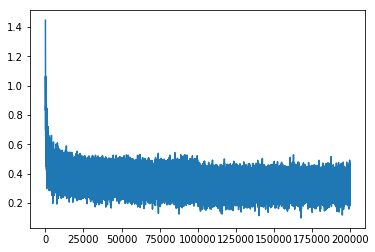

In [7]:
plt.plot(lossi)

In [8]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1217586994171143
val 2.162574052810669


In [9]:
Xtr.shape

torch.Size([182625, 3])

In [10]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmah.
amille.
khirmrex.
taty.
skanden.
jazonel.
den.
arci.
aqui.
ner.
kentzieiivia.
legy.
dham.
jorn.
quintis.
lilea.
jadii.
waythoniearynix.
kaeliigh.
boe.


In [11]:
# at the very first iteration, our loss is 27. and then we go to 2 .. it means our initialization is very bad
# at init, the prob distribiton should assign equal prob to all
# (because we have no reason to belive one is more likely than other)
# prob = 1/27 
# loss = 3.29 (if you take the nll of prob 1/27)
# at init, the network is very confidently wrong.
# we want the logits to be equal (close to 0), so that the prob coming out post softmax is roughly same for all.
# logits = h @ W2 (ignore b for now)
# logits = h @ (W2 * 0.1) 
# we dont multiple W2 by 0 because that causes 
# let's test . first we should run the initialization cell (run the initialization cell above)

In [12]:
max_steps = 200000
batch_size = 32 # to take a minibatch of data 
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb , Yb = Xtr[ix] , Ytr[ix] #batch X,Y
    
    # forward pass
    emb = C[Xb] #embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ (W2 * 0.1)  + b2 * 0
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
  
    # update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay over time
    for p in parameters:
        p.data += -lr * p.grad

    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.0360


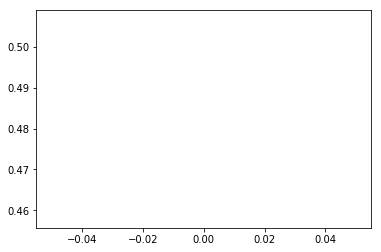

In [13]:
# we start with a much smaller loss now (around 4)! 
plt.plot(lossi)

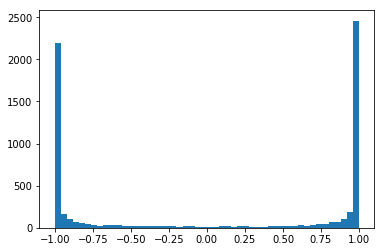

In [14]:
# now let's get make some improvements on the hidden layer. Let's visuaize h
plt.hist(h.view(-1).tolist() , 50);
# show's that the tanh is very very active. most of the values fall in -1 and +1 . h = torch.tanh(hpreact)

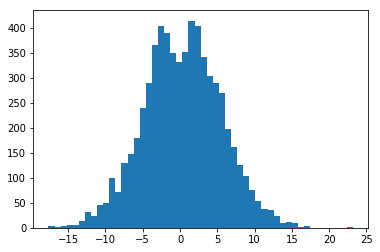

In [15]:
plt.hist(hpreact.view(-1).tolist() , 50); # similarly we see the distribution of hpreact is very broad (take -40 to 40 
#which is very extreme values)

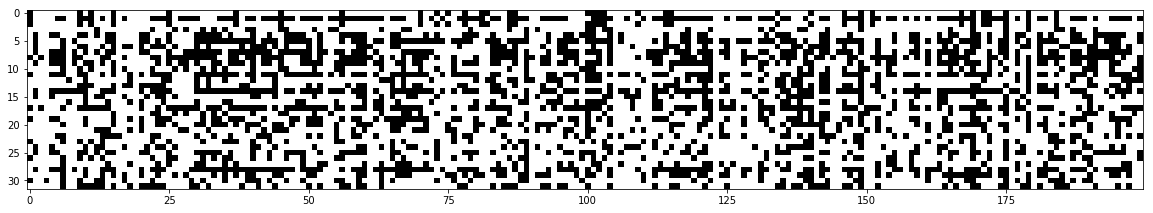

In [16]:
# during backprop, the tanh layer grad is (1-t**2) * out.grad
# if t = 1 or -1 , we get 0. Means the grad stops to flow back to the network. if t = 0 , the gradient out.grad just passes 
# through . so the grad flowing thorugh tanh can only decrease from out.grad to 0 . we dont want gradient go to 0 
# because that leads to dead neurons. if you have dead neurons, the gradient dont flow, which means the weights and biases
# dont update or dont learn.

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99 , cmap = 'gray', interpolation = 'nearest') # white = true, black = false.
# we see a lot of whites, which means all these tanh neurons are getting destroyed (the gradient is not passing through)
# all squashing functions have this property. relu, sigmoid, tanh. some alternatives are leaky relu, elu etc

In [17]:
# always run this cell (initialization) before optimization
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 # for tanh 
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1 # for logits
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2 , b2]

print('Number of parameters in total ' , sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

Number of parameters in total  11897


In [18]:
max_steps = 200000
batch_size = 32 # to take a minibatch of data 
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb , Yb = Xtr[ix] , Ytr[ix] #batch X,Y
    
    # forward pass
    emb = C[Xb] #embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
  
    # update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay over time
    for p in parameters:
        p.data += -lr * p.grad

    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 4.2304


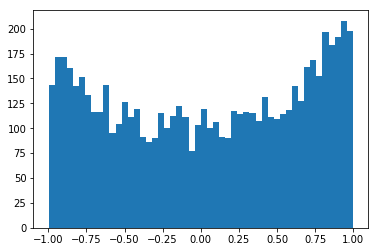

In [19]:
plt.hist(h.view(-1).tolist() , 50); # much better

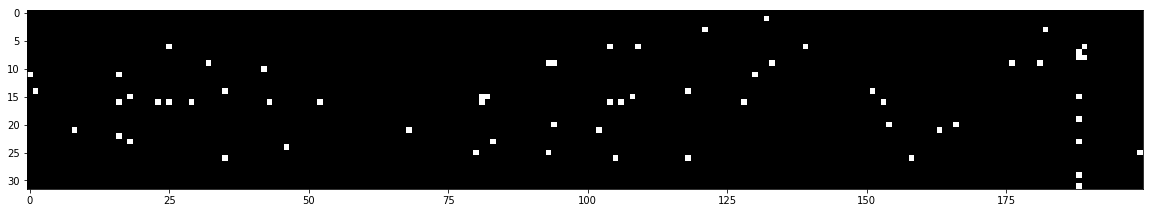

In [20]:

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99 , cmap = 'gray', interpolation = 'nearest') # lesser neurons are saturating. because our
# initialization is better

In [21]:
# initialization becomes difficult as your NN grows. no one does it by hand.
# there are research papers that dictate what should the values be for initialization. paper by kaiming he
# if you properly initialize the forward pass, the backprop works good as well for large NN
# torch.nn.kaiming
# also we define gain. gain is boost required to get the data back close the input std deviation (since tanh squshes the 
# input, it changes the st dev of data. we want the std dev to be same at all times. so we boost after a squashing layer) 
# https://pytorch.org/docs/stable/nn.init.html

# always run this cell (initialization) before optimization
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / (n_embd * block_size)**0.5) # for tanh. kaiming init
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1 # for logits
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2 , b2]

print('Number of parameters in total ' , sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

Number of parameters in total  11897


In [22]:
# now we study batch normalization 
# we dont want hidden states to be too small or too large. we want to roughly gaussian at init.
# BN says that you take the hidden state and normalize them to get unit gaussian state. these operations are differentiable
# so works for backward prop too
hmean, hstd = hpreact.mean(0, keepdims = True) , hpreact.std(0, keepdims = True)
(hpreact - hmean) / hstd # every neuron now has unit gaussian state i.e The distribution has zero mean and variance equal to 1

# problem is we want this at initialization only, not at all times. we want this distribution to move around
# so we do a scale(bngain) and shift(bnbias) 
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
hpreact = bngain * (hpreact - hpreact.mean(0, keepdims = True)) / hpreact.std(0, keepdims = True) + bnbias

In [23]:

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / (n_embd * block_size)**0.5) # for tanh. kaiming init
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1 # for logits
b2 = torch.randn(vocab_size,                      generator=g)


bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2 , b2 , bngain , bnbias]

print('Number of parameters in total ' , sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

Number of parameters in total  12297


In [24]:
max_steps = 200000
batch_size = 32 # to take a minibatch of data 
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb , Yb = Xtr[ix] , Ytr[ix] #batch X,Y
    
    # forward pass
    emb = C[Xb] #embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdims = True)) / hpreact.std(0, keepdims = True) + bnbias # BN
    
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
  
    # update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay over time
    for p in parameters:
        p.data += -lr * p.grad

    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 4.2651


In [25]:
# the problem now is that at prediction, we are dependent on a batch of data to calculate mean and std.
# but at test time we only get one example. so how do we cal mean and std ?
# solution is to keep the mean and std of the batch in a running manner during training


n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / (n_embd * block_size)**0.5) # for tanh. kaiming init
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1 # for logits
b2 = torch.randn(vocab_size,                      generator=g)

# Batch normalization
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

#keep track of running mean and std
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2 , b2 , bngain , bnbias]

print('Number of parameters in total ' , sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

Number of parameters in total  12297


In [26]:
max_steps = 200000
batch_size = 32 # to take a minibatch of data 
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb , Yb = Xtr[ix] , Ytr[ix] #batch X,Y
    
    # forward pass
    emb = C[Xb] #embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    
    hpreact = embcat @ W1 # hidden layer pre-activation. dont need the b1 bias now, since we now have bnbias
    
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # BN
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # keep bnmean_running almost same, but slightly update with new batch mean
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
  
    # update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay over time
    for p in parameters:
        p.data += -lr * p.grad

    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [ ]:
# for test
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # now we can simply use the bnmean_running and bnstd_running we tracked during training
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# SUMMARY + PYTORCHIFYING -----------

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5  # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None # whether or not we want a bias for linear layer
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps # from batcnorm paper, to make sure we dont divide by zero
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta # same as scale(bngain) and shift(bnbias)
        
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1 # make output softmax/logit a less confident
    # all other layers: apply gain
    for layer in layers[:-1]: # apply a gain of 5/3 to every tanh layer
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # weights were initialized with torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5. so we just need to multiply by 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x) # invokes the __call__ method of each class in layer
    loss = F.cross_entropy(x, Yb) # loss function
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    

    break # AFTER_DEBUG: would take out obviously to run full optimization

In [ ]:
# visualize histograms of activations. The reason saturation is good for tanh layers of our kaiming. Note : all layers
# are well behaved , they follow the same graph
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [ ]:
# visualize histograms of gradients
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)


layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]


with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # to keep track of update to data ratio


for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x) # invokes the __call__ method of each class in layer
    loss = F.cross_entropy(x, Yb) # loss function
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters]) # update std : lr*p.grad.std() to data std : p.data.std() for every parameter
    
    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);